# 使用 async 控制并发

## 目标

建立一个 `lesson5` 项目，在其中编写代码。

代码的入口是 `app.js`，当调用 `node app.js` 时，它会输出 [CNode](https://cnodejs.org/) 社区首页的所有主题的标题，链接和第一条评论，以 `json` 格式。

注意：与上节课不同，并发连接数需要控制在 5 个。

输出示例：

```
[
  {
    "title": "【公告】发招聘帖的同学留意一下这里",
    "href": "http://cnodejs.org/topic/541ed2d05e28155f24676a12",
    "comment1": "呵呵呵呵"
  },
  {
    "title": "发布一款 Sublime Text 下的 JavaScript 语法高亮插件",
    "href": "http://cnodejs.org/topic/54207e2efffeb6de3d61f68f",
    "comment1": "沙发！"
  }
]
```
## 知识点

1. 学习 [async](https://github.com/caolan/async) 的使用。这里有个详细的 `async demo` 演示：https://github.com/alsotang/async_demo 2. 学习使用 `async` 来控制并发连接数。
    
## 课程内容

`lesson4` 的代码其实是不完美的。为什么这么说，是因为在 `lesson4` 中，我们一次性发了 `40` 个并发请求出去，要知道，除去 `CNode` 的话，别的网站有可能会因为你发出的并发连接数太多而当你是在恶意请求，把你的 `IP` 封掉。

我们在写爬虫的时候，如果有 `1000` 个链接要去爬，那么不可能同时发出 `1000` 个并发链接出去对不对？我们需要控制一下并发的数量，比如并发 `10` 个就好，然后慢慢抓完这 `1000` 个链接。

用 `async` 来做这件事很简单。

这次我们要介绍的是 `async` 的 `mapLimit(arr, limit, iterator, callback)` 接口。另外，还有个常用的控制并发连接数的接口是 `queue(worker, concurrency)`,大家可以去 https://github.com/caolan/async#queueworker-concurrency 看看说明。

这回我就不带大家爬网站了，我们来专注知识点：并发连接数控制。

对了，还有个问题是，什么时候用 `eventproxy` ，什么时候使用 `async` 呢？它们不都是用来做异步流程控制的吗？

我的答案是：

当你需要去多个源（一般是小于 10 个）汇总数据的时候，用 `eventproxy` 方便；当你需要用到队列，需要控制并发数，或者你喜欢函数式编程思维时，使用 `async`。大部分场景是前者，所以我个人大部分时间是用 `eventproxy` 的。

* [选择题 ★★ 理解并掌握各种编程范型，对于 coder 有什么好处，你认同哪个观点？](https://xue.cn/hub/app/exercise/1864)

正题开始。

首先，我们伪造一个 `fetchUrl(url, callback)` 函数，这个函数的作用就是，当你通过

```
fetchUrl('http://www.baidu.com', function (err, content) {
    // do something with `content`
});

```

调用它时，它会返回 http://www.baidu.com 的页面内容回来。

当然，我们这里的返回内容是假的，返回延时是随机的。并且在它被调用时，会告诉你它现在一共被多少个地方调用着。

```
// 并发连接数的计数器
var concurrencyCount = 0;
var fetchUrl = function (url, callback) {
  // delay 的值在 2000 以内，是个随机的整数
  var delay = parseInt((Math.random() * 10000000) % 2000, 10);
  concurrencyCount++;
  console.log('现在的并发数是', concurrencyCount, '，正在抓取的是', url, '，耗时' + delay + '毫秒');
  setTimeout(function () {
    concurrencyCount--;
    callback(null, url + ' html content');
  }, delay);
};
```

我们接着来伪造一组链接

```
var urls = [];
for(var i = 0; i< 30; i++) {
    urls.push('http://datasource_' + i);
}
```

这组链接长这样：

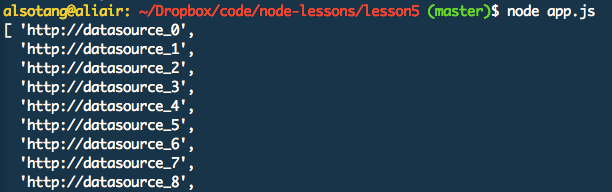

接着，我们使用 `async.mapLimit` 来并发抓取，并获取结果。
```
async.mapLimit(urls, 5, function(url, callback) {
    fetchUrl(url, callback);
},function (err, result) {
    console.log('final:');
    console.log(result);
});
```
运行输出是这样的:

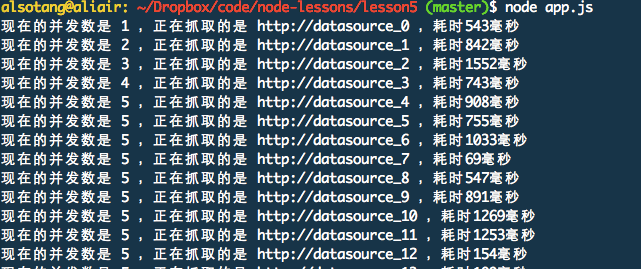

可以看到，一开始，并发链接数是从 1 开始增长的，增长到 5 时，就不再增加。当其中有任务完成时，再继续抓取。并发连接数始终控制在 5 个。

完整代码请参见 `app.js` 文件。

